In [0]:
%tensorflow_version 2.x 
import tensorflow as tf 
import numpy as np 
import pandas as pd 
from keras.models import load_model, Model
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.layers import GlobalAveragePooling2D,Conv2D,Flatten,Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [0]:
from google.colab import files
files.upload()


In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 2.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=49d2d6541bad169cf0abc425694569b214975f7c685cbc396dc06c4171f88b2a
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure

In [0]:
!kaggle datasets download -d ahmetfurkandemr/mask-datasets-v1

100% 751M/754M [00:17<00:00, 39.6MB/s]
100% 754M/754M [00:17<00:00, 46.0MB/s]


In [0]:
from zipfile import ZipFile
file_name="mask-datasets-v1.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
train_imagedatagenerator=ImageDataGenerator(
                            horizontal_flip=True,
                            rescale=1/255,
                            validation_split=0.1,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=.1,
                            fill_mode='nearest',
                            shear_range=0.1,
                            
                            brightness_range=[0.5, 1.5]
    
)
test_imagedatagenerator=ImageDataGenerator(
    rescale=1/255
)


In [0]:
train= train_imagedatagenerator.flow_from_directory(
    directory="/content/Mask_Datasets/Train",
    target_size=(224,224),
    batch_size=64,
    class_mode="binary",
    subset="training",
    color_mode="rgb"
)
valid=train_imagedatagenerator.flow_from_directory(
    directory="/content/Mask_Datasets/Train",
    target_size=(224,224),
    batch_size=64,
    class_mode="binary",
    subset="validation",
    color_mode="rgb",
)
test=test_imagedatagenerator.flow_from_directory(
    directory="/content/Mask_Datasets/Validation",
     target_size=(224,224),
    batch_size=64,
    class_mode="binary",
    shuffle=False,
    color_mode="rgb"
)


Found 675 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [0]:
mobilenet_model=MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))
x=mobilenet_model.output
x=GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
predictions=Dense(1,activation="sigmoid")(x)

model1=Model(inputs=mobilenet_model.input,outputs=predictions)

for layer in model1.layers[:68]:
  layer.trainable=False

model1.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [0]:
layers_info=[(layer,layer.name,layer.trainable) for layer in model1.layers]

layer_info=pd.DataFrame(layers_info,columns=['layer_type','layer_name','trainable'])
layer_info.tail(25)

,layer_type,layer_name,trainable
66,<keras.layers.normalization.BatchNormalization...,conv_pw_10_bn,False
67,<keras.layers.advanced_activations.ReLU object...,conv_pw_10_relu,False
68,<keras.layers.convolutional.DepthwiseConv2D ob...,conv_dw_11,True
69,<keras.layers.normalization.BatchNormalization...,conv_dw_11_bn,True
70,<keras.layers.advanced_activations.ReLU object...,conv_dw_11_relu,True
71,<keras.layers.convolutional.Conv2D object at 0...,conv_pw_11,True
72,<keras.layers.normalization.BatchNormalization...,conv_pw_11_bn,True
73,<keras.layers.advanced_activations.ReLU object...,conv_pw_11_relu,True
74,<keras.layers.convolutional.ZeroPadding2D obje...,conv_pad_12,True
75,<keras.layers.convolutional.DepthwiseConv2D ob...,conv_dw_12,True


In [0]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [0]:
model_checkpoint=ModelCheckpoint('best_mobile_net.h5',monitor='val_accuracy',save_best_only=True,mode='max')
early_stopping=EarlyStopping(monitor="val_accuracy",min_delta=0,patience=10,verbose=0,mode="max",restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="loss",factor=0.2,patience=10,min_lr=0.001)

In [0]:
history1=model1.fit_generator(train,epochs=20,steps_per_epoch=train.n//train.batch_size,validation_data=valid,verbose=1,callbacks=[model_checkpoint,early_stopping,reduce_lr])

Epoch 1/20
10/10 [==============================] - 24s 2s/step - loss: 0.0111 - accuracy: 0.9984 - val_loss: 2.4012 - val_accuracy: 0.8800
Epoch 2/20
10/10 [==============================] - 20s 2s/step - loss: 0.0279 - accuracy: 0.9951 - val_loss: 0.1748 - val_accuracy: 0.8800
Epoch 3/20
10/10 [==============================] - 21s 2s/step - loss: 0.0061 - accuracy: 0.9967 - val_loss: 0.1330 - val_accuracy: 0.8533
Epoch 4/20
10/10 [==============================] - 22s 2s/step - loss: 0.0244 - accuracy: 0.9935 - val_loss: 1.4274 - val_accuracy: 0.8933
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 0.0084 - accuracy: 0.9969 - val_loss: 7.4656e-05 - val_accuracy: 0.9733
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.3980 - val_accuracy: 0.9467
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.0195 - accuracy: 0.9951 - val_loss: 1.3474e-15 - val_accuracy: 0.9733
Epoch 8/20
1

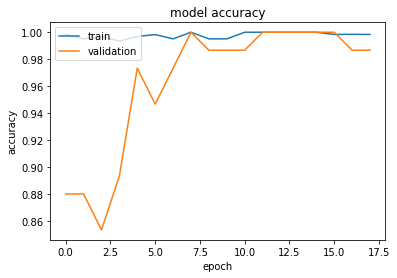

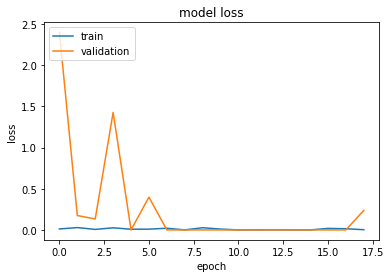

In [0]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model1.save('mobilenet_model.h5')

In [0]:
test.reset()

In [0]:

y_pred=model1.predict_generator(test,verbose=1)

6/6 [==============================] - 10s 2s/step


In [0]:
y_pred_final=[]
for i in range(len(y_pred)):
  if y_pred[i]>0.5:
    y_pred_final.append(1)
  else:
    y_pred_final.append(0)

In [0]:
y_pred_final

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [0]:
test.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [0]:
y_true=test.labels

In [0]:
print("accuracy score ",accuracy_score(y_true,y_pred_final),"roc auc score",roc_auc_score(y_true,y_pred_final))

accuracy score  1.0 roc auc score 1.0


In [0]:
image_path="/content/w-no-mask4.jpg"
test_image2 = image.load_img(image_path, target_size = (224, 224)) 
test_arr = image.img_to_array(test_image2)
test_arr = np.expand_dims(test_arr, axis = 0)
test_arr /= 255.0
#predict the result
result = model1.predict(test_arr)
print(result[0])
if result>0.5:
  print("no-mask")
else:
  print("mask")

[1.]
no-mask
